# ATP6V0C


In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.5.1.dev0


### ATP6V0C
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ATP6V0C.

In [2]:
gene_symbol = 'ATP6V0C'
mane_tx_id = 'NM_001694.4'
mane_protein_id = 'NP_001685.1' # V-type proton ATPase 16 kDa proteolipid subunit c [Homo sapiens]

In [5]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 24/24 [00:40<00:00,  1.69s/individuals]
Validated under permissive policy
No errors or warnings were found


In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,21
Bilateral tonic-clonic seizure,HP:0002069,13
Generalized non-motor (absence) seizure,HP:0002121,6
Atonic seizure,HP:0010819,6
Myoclonic seizure,HP:0032794,5
"Intellectual disability, severe",HP:0010864,4
"Intellectual disability, profound",HP:0002187,4
Febrile seizure (within the age range of 3 months to 6 years),HP:0002373,4
Focal-onset seizure,HP:0007359,4
Tonic seizure,HP:0032792,4


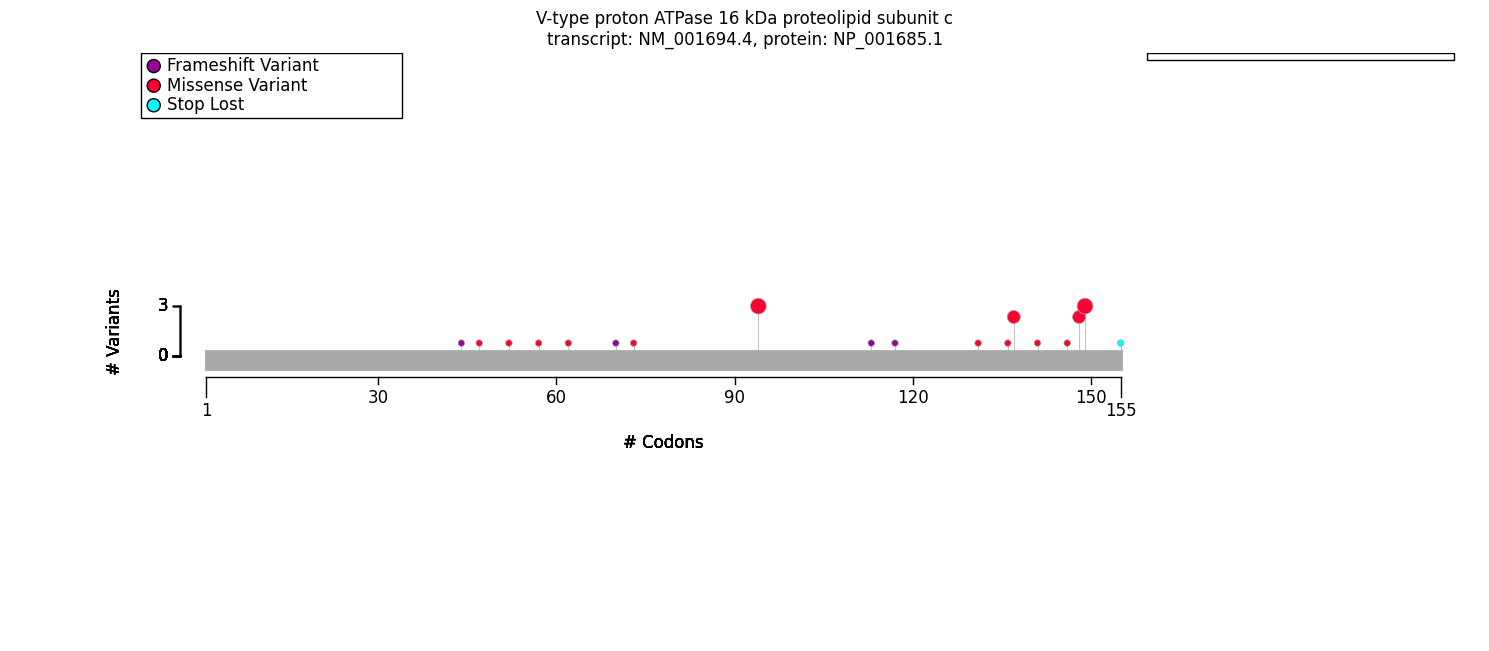

In [9]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [11]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
     term_frequency_threshold=0.2,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [14]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(0,100), tx_id=mane_tx_id)

n_term_predicate = monoallelic_predicate(a_predicate=n_term, b_predicate=~ n_term, names=("1-100", "100+"))
n_term_predicate.display_question()

'Allele group: 1-100, 100+'

In [16]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=n_term_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF06,Skipping term with less than 7 observations (not powered for 2x2),8
HMF08,Skipping general term,5
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,13


In [17]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                 1-100           100+          \
                                             Count Percent  Count Percent   
Global developmental delay [HP:0001263]        8/9     89%  13/14     93%   
Neurodevelopmental delay [HP:0012758]          8/8    100%  13/13    100%   
Neurodevelopmental abnormality [HP:0012759]  10/10    100%  13/13    100%   
Intellectual disability [HP:0001249]           5/5    100%  10/10    100%   
Bilateral tonic-clonic seizure [HP:0002069]    5/5    100%  10/10    100%   
Seizure [HP:0001250]                           8/8    100%  11/11    100%   
Focal-onset seizure [HP:0007359]               4/4    100%    4/4    100%   
Dialeptic seizure [HP:0011146]                 4/4    100%    3/3    100%   
Motor seizure [HP:0020219]                     4/4    100%    6/6    100%   

Allele group                                                             
                                            Corrected p values p values  
Global developmental delay [HP:0001263]                    1.0      1.0  
Neurodevelopmental delay [HP:0012758]                      1.0      1.0  
Neurodevelopmental abnormality [HP:0012759]                1.0      1.0  
Intellectual disability [HP:0001249]                       1.0      1.0  
Bilateral tonic-clonic seizure [HP:0002069]                1.0      1.0  
Seizure [HP:0001250]                                       1.0      1.0  
Focal-onset seizure [HP:0007359]                           1.0      1.0  
Dialeptic seizure [HP:0011146]                             1.0      1.0  
Motor seizure [HP:0020219]                                 1.0      1.0